In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'emotions:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4403839%2F7563141%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240403%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240403T015232Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4a938dc13212dc06016f6ce641109a0ee9e3214eb3977a245aa4c92c5f937c4aab02d5705a14871a58a53fab9af64011e4e6a0d8c6b40b6acca7d39f9e31dd41b7abd9e5278b60a3ff6151342fb815f92a33c2652194e8ec3848f90c79ee69d3f12383de47d5942c03362e7a32de97423027af8626099795ba4f58d8437d6c7035cc5c7690496c41867ea064a6ba8b056c12044921fda0a658fa9553cf0989376597a37b5570c3444c90a96f49a2cd5d9fabc9d3e9f8f9099350077af9ffe4af119551079f61d23dc5e6da68c571fa71b1c53bca33bf6a5cf4cb9345c008046627527aef805150ee6424d12cdec086d8d10ed26f14415c756d8c1014077615bf'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16440679 bytes downloaded
Downloaded and uncompressed: emotions
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions/text.csv


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/kaggle/input/emotions/text.csv')

# Data Exploration

In [ ]:
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [ ]:
df.duplicated().sum()

686

In [ ]:
df = df.drop_duplicates()

In [ ]:
# mapping emotions
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

df['label_emotion'] = df['label'].map(emotion_map)

<ipython-input-10-d7ea3e559667>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_emotion'] = df['label'].map(emotion_map)


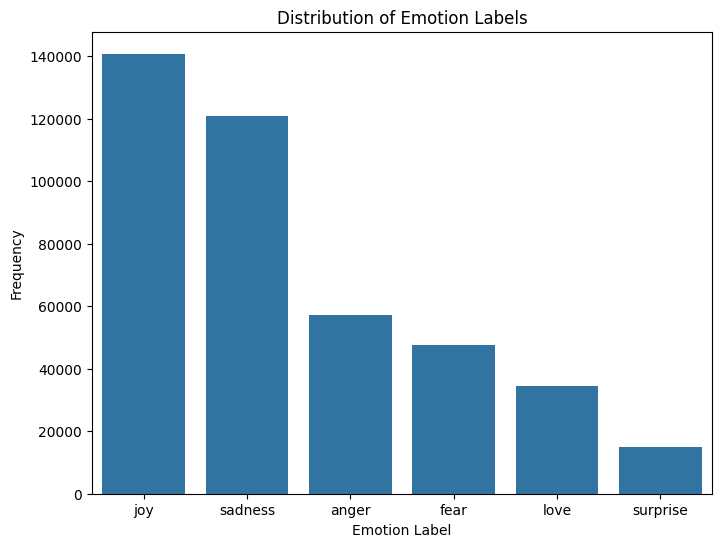

In [ ]:
# check label distribution
label_counts = df['label_emotion'].value_counts()

# plot label distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Emotion Labels')
plt.xlabel('Emotion Label')
plt.ylabel('Frequency')
plt.show()

In [ ]:
label_counts

joy         140779
sadness     120989
anger        57235
fear         47664
love         34497
surprise     14959
Name: label_emotion, dtype: int64

From the label distribution, we can see that there is class imbalance in the dataset with some classes having significantly more samples than others.

# Data Cleaning & Preprocessing

In [ ]:
# removing punctuation and special characters, digits, white spaces
df['text'] = df['text'].str.replace('[^\w\s]', '')

<ipython-input-13-70b007434805>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[^\w\s]', '')


In [ ]:
#converting to lower case
df['text'] = df['text'].str.lower()

In [ ]:
# removing url's
df['text'] = df['text'].str.replace(r'https?://\S+|www\.\S+', '', regex=True)

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
# function to remove stop words using spacy
def remove_stopwords(text):
    doc = nlp(text)
    filtered_text = [token.text for token in doc if not token.is_stop]
    return ' '.join(filtered_text)

df['text'] = df['text'].apply(remove_stopwords)

In [ ]:
#def lemmatize_text_spacy(text):
#    doc = nlp(text)
#    lemma_words = [token.lemma_ for token in doc]
#    lemma_text = ' '.join(lemma_words)
#    return lemma_text

#df['text'] = df['text'].apply(lemmatize_text_spacy)

In [ ]:
df['text'][0:5]

0                          feel helpless heavy hearted
1    ve enjoyed able slouch relax unwind frankly ne...
2              gave internship dmrg feeling distraught
3                                    nt know feel lost
4    kindergarten teacher thoroughly weary job havi...
Name: text, dtype: object

In [ ]:
# TF-IDF Vectorization
#tfidf_vectorizer = TfidfVectorizer(max_features=1000)
#tfidf_features = tfidf_vectorizer.fit_transform(df['text']).toarray()

# Convert TF-IDF features to DataFrame
#tfidf_df = pd.DataFrame(tfidf_features, columns=tfidf_vectorizer.get_feature_names_out())
#tfidf_df.head()

# Data Modelling - Part 1 (Exploring Bi-LSTM model)

In [ ]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.2, random_state=50,stratify=df["label"])

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# convert to lowercase
X_train_texts = [str(text).lower() for text in X_train]
X_test_texts = [str(text).lower() for text in X_test]

# Initialize Tokenizer
tokenizer = Tokenizer(num_words=60000)
tokenizer.fit_on_texts(X_train_texts)

vocab_size = len(tokenizer.word_index) + 1
max_seq_length = 100

# Convert text sequences to numerical sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_test_seq = tokenizer.texts_to_sequences(X_test_texts)

# Pad sequences to ensure uniform length for modeling
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_seq_length, padding='post')
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_seq_length, padding='post')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, BatchNormalization, Dropout

# Define the Sequential model

embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(100,)),
    Bidirectional(LSTM(128)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

In [ ]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

num_epochs = 5  # Define number of epochs
batch_size = 32  # Define batch size

history = model.fit(X_train_padded, y_train_encoded, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test_padded, y_test_encoded))

Epoch 1/5
10404/10404 [==============================] - 178s 16ms/step - loss: 0.2437 - accuracy: 0.8987 - val_loss: 0.1169 - val_accuracy: 0.9312
Epoch 2/5
10404/10404 [==============================] - 146s 14ms/step - loss: 0.1196 - accuracy: 0.9342 - val_loss: 0.1104 - val_accuracy: 0.9340
Epoch 3/5
10404/10404 [==============================] - 153s 15ms/step - loss: 0.1091 - accuracy: 0.9378 - val_loss: 0.1062 - val_accuracy: 0.9371
Epoch 4/5
10404/10404 [==============================] - 156s 15ms/step - loss: 0.1039 - accuracy: 0.9388 - val_loss: 0.1130 - val_accuracy: 0.9365
Epoch 5/5
10404/10404 [==============================] - 145s 14ms/step - loss: 0.0992 - accuracy: 0.9401 - val_loss: 0.1073 - val_accuracy: 0.9368


# Inference

In [ ]:
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

2601/2601 [==============================] - 14s 5ms/step - loss: 0.1073 - accuracy: 0.9368
Test Loss: 0.10728257149457932, Test Accuracy: 0.9367978572845459


In [ ]:
new_texts = ['It was a depressing moment', 'I am pissed off and sad today','This is a fine moment', 'I feel okay today']
new_texts_seq = tokenizer.texts_to_sequences(new_texts)
new_texts_padded = tf.keras.preprocessing.sequence.pad_sequences(new_texts_seq, maxlen=max_seq_length, padding='post')

predictions = model.predict(new_texts_padded)
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))
print(predicted_labels)

1/1 [==============================] - 0s 26ms/step
[0 0 3 0]


In [ ]:
# Test Predictions
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

2601/2601 [==============================] - 11s 4ms/step


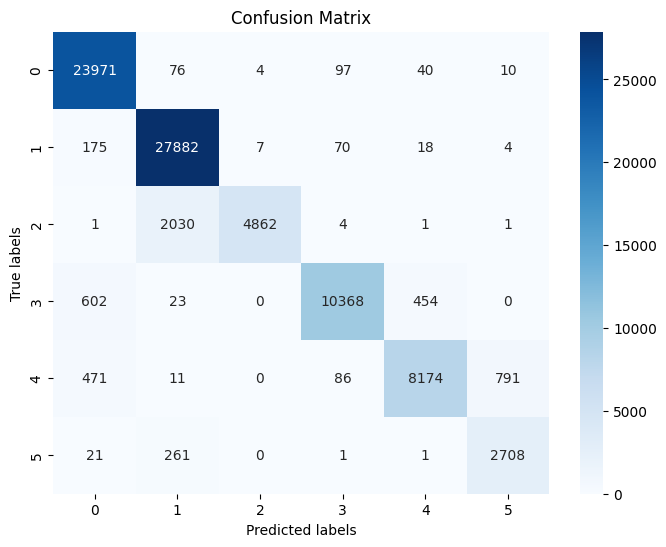

In [ ]:
from sklearn.metrics import confusion_matrix

cm_lstm = confusion_matrix(y_test_encoded, y_pred)

# Plot confusion matrix with blue color
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("\nConfusion matrix - LSTM:")
cm_lstm


Confusion matrix - LSTM:


array([[23971,    76,     4,    97,    40,    10],
       [  175, 27882,     7,    70,    18,     4],
       [    1,  2030,  4862,     4,     1,     1],
       [  602,    23,     0, 10368,   454,     0],
       [  471,    11,     0,    86,  8174,   791],
       [   21,   261,     0,     1,     1,  2708]])

The confusion matrix shows that the model performs well in correctly predicting instances for classes with higher support ('sadness', 'joy', 'anger') but shows inconsistencies and misclassifications for classes with lower support ('love', 'surprise').

In [ ]:
# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     24198
           1       0.92      0.99      0.95     28156
           2       1.00      0.70      0.83      6899
           3       0.98      0.91      0.94     11447
           4       0.94      0.86      0.90      9533
           5       0.77      0.91      0.83      2992

    accuracy                           0.94     83225
   macro avg       0.93      0.89      0.90     83225
weighted avg       0.94      0.94      0.94     83225



# Inference from classification report:

Model seems to performing very well in predicting emotions as evidenced by the accuracy and classification metrics.

1.   Precision: The model performed well in terms of precision for 'sadness', 'joy', 'anger', and 'fear'. This indicates that the model made fewer false positive predictions for these classes.

2.   Recall: The recall values vary across classes, with some classes having high recall ('sadness', 'joy', 'anger') while relatively lower for others ('love', 'surprise'). This suggests that the model correctly identified a high percentage of actual instances for some classes but may have missed some instances for other classes.

3.   F1-score: It shows a balanced measure of precision and recall. The model achieved good F1-scores for most classes, indicating a balance between precision and recall. However, some classes like 'love' and 'surprise' have relatively lower F1-scores compared to others








> Overall the model is good at predicting dominant emotions ('sadness', 'joy', 'anger', 'fear') but may require further tuning to improve predictions for less represented emotions ('love', 'surprise').

